In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from array import array
import numpy as np
from pandas import read_csv
from sklearn.model_selection import train_test_split 
import tensorflow as tf
from matplotlib import pyplot as plt
import keras
from keras import layers
from keras.layers import Input, Dense, ConvLSTM2D,Conv2D, Conv2DTranspose,Dropout,Flatten,TimeDistributed,LayerNormalization
from keras.models import Model
import keras
from keras import layers
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.utils import to_categorical
from PIL import Image


In [ ]:
Datos3K=read_csv('/content/drive/MyDrive/Colab Notebooks/Segmentation/3KAutoEncoder.csv',delimiter=',', index_col=False)
#Datos3K = array(Datos3K)



In [ ]:
Datos3K = Datos3K.to_numpy()
Datos3K.shape


(451584, 100)

In [ ]:
Datos3K=Datos3K.transpose()

In [ ]:
print(Datos3K.shape)

(100, 451584)


In [ ]:
X =np.reshape(Datos3K,(Datos3K.shape[0],1,224,672,3))
X = X.astype('float32') / 255.
X.shape

(100, 1, 224, 672, 3)

In [ ]:
print(X.shape)

(100, 1, 224, 672, 3)


In [ ]:
Yvalues = []
for i in range(100): 
  Yvalues.append(i)
Yvalues= np.array(Yvalues)

In [ ]:
#Yvalues=Yvalues.reshape(50,1)
Yvalues.shape

(100,)

In [ ]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(Yvalues)

# Display the change for category label using one-hot encoding
print('Original label:', Yvalues[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 0
After conversion to one-hot: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
train_X,valid_X,train_label,valid_label = train_test_split(X,train_Y_one_hot,test_size=0.2)


In [ ]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(80, 1, 224, 672, 3) (20, 1, 224, 672, 3) (80, 100) (20, 100)


In [ ]:
num_classes=100
input_img = Input(shape=(1,224, 672, 3)) 
def encoder(input_img):
    #encoder
    #input = 224 x 672 x 3 (wide and thin) 
    x=TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 1, 224, 672, 3))(input_img)
    x=LayerNormalization()(x)
    x=TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same"))(x)
    x=LayerNormalization()(x)
    # # # # #
    x=ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True)(x)
    x=LayerNormalization()(x)
    encoded= ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True)(x)
    
    return encoded

def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    den= Dropout(0.2)(den)
    den = Dense(80, activation='relu')(den)
    den= Dropout(0.2)(den)
    out = Dense(num_classes, activation='softmax')(den)
    return out

encode = encoder(input_img)
autoencoderClassifier = Model(input_img,fc(encode))

In [ ]:
for l1,l2 in zip(autoencoderClassifier.layers[:7],autoencoderClassifier.layers[0:7]):
    l1.set_weights(l2.get_weights())

In [ ]:
autoencoderClassifier.get_weights()[0][1];

In [ ]:
for layer in autoencoderClassifier.layers[0:7]:
    layer.trainable = False

In [ ]:
autoencoderClassifier.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),metrics=['accuracy'])


In [ ]:
autoencoderClassifier.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 224, 672, 3)]  0         
                                                                 
 time_distributed (TimeDistr  (None, 1, 56, 168, 128)  46592     
 ibuted)                                                         
                                                                 
 layer_normalization (LayerN  (None, 1, 56, 168, 128)  256       
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 28, 84, 64)    204864    
 tributed)                                                       
                                                                 
 layer_normalization_1 (Laye  (None, 1, 28, 84, 64)    128       
 rNormalization)                                             

In [ ]:
classify_train = autoencoderClassifier.fit(train_X, train_label, batch_size=5,epochs=20,verbose=1,validation_data=(valid_X, valid_label))


Epoch 1/20
16/16 [==============================] - 12s 73ms/step - loss: 5.1025 - accuracy: 0.0125 - val_loss: 4.6341 - val_accuracy: 0.0500
Epoch 2/20
16/16 [==============================] - 0s 31ms/step - loss: 4.4186 - accuracy: 0.0375 - val_loss: 4.6764 - val_accuracy: 0.0000e+00
Epoch 3/20
16/16 [==============================] - 0s 26ms/step - loss: 3.6769 - accuracy: 0.1500 - val_loss: 5.0605 - val_accuracy: 0.0000e+00
Epoch 4/20
16/16 [==============================] - 1s 38ms/step - loss: 2.3817 - accuracy: 0.4500 - val_loss: 6.0098 - val_accuracy: 0.0000e+00
Epoch 5/20
16/16 [==============================] - 0s 27ms/step - loss: 1.2589 - accuracy: 0.6250 - val_loss: 7.0365 - val_accuracy: 0.0000e+00
Epoch 6/20
16/16 [==============================] - 0s 32ms/step - loss: 0.8325 - accuracy: 0.7375 - val_loss: 6.5158 - val_accuracy: 0.0000e+00
Epoch 7/20
16/16 [==============================] - 0s 28ms/step - loss: 0.5890 - accuracy: 0.8750 - val_loss: 8.3944 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


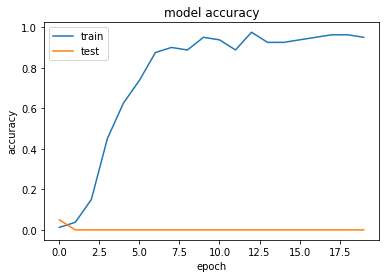

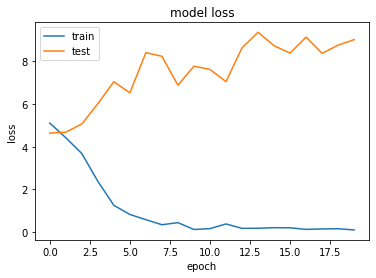

In [ ]:
print(classify_train.history.keys())
# summarize history for accuracy
plt.plot(classify_train.history['accuracy'])
plt.plot(classify_train.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(classify_train.history['loss'])
plt.plot(classify_train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_eval = autoencoderClassifier.evaluate(valid_X, valid_label, verbose=0)


In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 9.003280639648438
Test accuracy: 0.0


In [ ]:
predicted_classes = autoencoderClassifier.predict(X)


4/4 [==============================] - 1s 94ms/step


In [ ]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)


In [ ]:
predicted_classes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  0, 14, 15, 16,
        0, 18, 19, 20,  0, 22,  0, 24, 25,  0, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43,  0, 45, 46, 47, 48, 12, 50,
       51, 52, 53, 54, 55,  0,  0, 58, 59,  0, 61, 62, 63, 64, 65, 66, 67,
        0, 69,  0, 53, 72,  0, 74, 75,  0,  0, 78, 79, 80, 81, 82,  0, 84,
        6, 86, 87, 88,  0, 90,  0, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
predicted_classes.shape, Yvalues.shape


((100,), (100,))

Found 20 incorrect labels


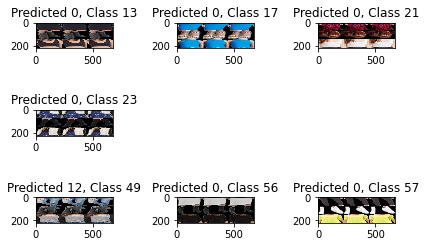

In [ ]:
incorrect = np.where(predicted_classes!=Yvalues)[0]
print ("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X[incorrect].reshape(224,672,3), interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], Yvalues[incorrect]))
    plt.tight_layout()

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(Yvalues, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.06      1.00      0.11         1
     Class 1       1.00      1.00      1.00         1
     Class 2       1.00      1.00      1.00         1
     Class 3       1.00      1.00      1.00         1
     Class 4       1.00      1.00      1.00         1
     Class 5       1.00      1.00      1.00         1
     Class 6       0.50      1.00      0.67         1
     Class 7       1.00      1.00      1.00         1
     Class 8       1.00      1.00      1.00         1
     Class 9       1.00      1.00      1.00         1
    Class 10       1.00      1.00      1.00         1
    Class 11       1.00      1.00      1.00         1
    Class 12       0.50      1.00      0.67         1
    Class 13       0.00      0.00      0.00         1
    Class 14       1.00      1.00      1.00         1
    Class 15       1.00      1.00      1.00         1
    Class 16       1.00      1.00      1.00         1
    Class 17       0.00    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
autoencoderClassifier.save('2. Without Data Augmentation Encoder Classification ConvLSTM.h5')